# Modeling, Probability Segmentation & Score Binning of "Give me Credit" Kaggle Dataset with engineered features

## Modeling

In [1]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading dataset
df = pd.read_csv("engineered_credit_data_scaled.csv")

In [4]:
# Preparing data
X = df.drop(columns=['SeriousDlqin2yrs'])
X = pd.get_dummies(X, drop_first=True)
Y = df['SeriousDlqin2yrs']

In [5]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42,stratify=Y)

In [6]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train,Y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

In [7]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

In [8]:
# Evaluation function
def evaluate_model(y_true,y_pred,y_prob,model_name):
    print(f"\n {model_name} Evaluation Metrics")
    print("Confusion Matrix: \n", confusion_matrix(y_true,y_pred))
    print("Classification Report:\n", classification_report(y_true,y_pred))
    print("AUC-ROC Score:", roc_auc_score(y_true,y_prob))
    print("Precision:", precision_score(y_true,y_pred))
    print("Recall:", recall_score(y_true, y_pred))

In [9]:
# Evaluating both models
evaluate_model(Y_test, y_pred_log, y_prob_log, "Logistic Regression")
evaluate_model(Y_test, y_pred_rf, y_prob_rf, "Random Forest")


 Logistic Regression Evaluation Metrics
Confusion Matrix: 
 [[27620   286]
 [ 1596   378]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     27906
           1       0.57      0.19      0.29      1974

    accuracy                           0.94     29880
   macro avg       0.76      0.59      0.63     29880
weighted avg       0.92      0.94      0.92     29880

AUC-ROC Score: 0.8524229845005061
Precision: 0.5692771084337349
Recall: 0.19148936170212766

 Random Forest Evaluation Metrics
Confusion Matrix: 
 [[27613   293]
 [ 1606   368]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     27906
           1       0.56      0.19      0.28      1974

    accuracy                           0.94     29880
   macro avg       0.75      0.59      0.62     29880
weighted avg       0.92      0.94      0.92     29880

AUC-ROC Score: 0.83506913243

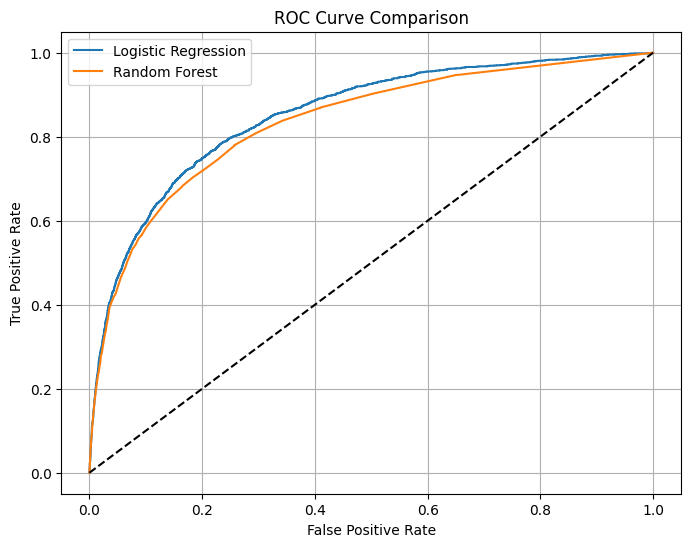

In [11]:
# Plot ROC Curve
fpr_log, tpr_log, _ = roc_curve(Y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(Y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1],[0,1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Probability Segmentation & Score Binning

Objective here is to take predicted Probability of Default (PD) from Logistic or RF and split it into risk bands, such as:
- **A:** Very Low Risk (approve)
- **B:** Low Risk (approve with caution)
- **C:** Medium Risk (manual review)
- **D:** High Risk (high APR or secured only)
- **E:** Very High Risk (decline)

In [13]:
# Using predictions from Logistic Regression (AUC-ROC Score and Precision is higher)
df_scores = X_test.copy()
df_scores['TrueDefault'] = Y_test.values
df_scores['PD_Log'] = y_prob_log

In [14]:
# Creating score bands using quantiles
df_scores['RiskBand'] = pd.cut(
    df_scores['PD_Log'],
    bins=[0.0, 0.05, 0.10, 0.20, 0.35, 1.0],
    labels=['A','B','C','D','E']
)

In [15]:
# Showing band distribution
print("\n Risk Band Distribution:")
print(df_scores['RiskBand'].value_counts().sort_index())


 Risk Band Distribution:
RiskBand
A    20939
B     4487
C     2283
D     1085
E     1086
Name: count, dtype: int64


In [16]:
# Default rate per risk band
default_rate = df_scores.groupby('RiskBand')['TrueDefault'].mean().round(3)
print("\n Default Rate per Risk Band:")
print(default_rate)


 Default Rate per Risk Band:
RiskBand
A    0.018
B    0.076
C    0.158
D    0.299
E    0.517
Name: TrueDefault, dtype: float64


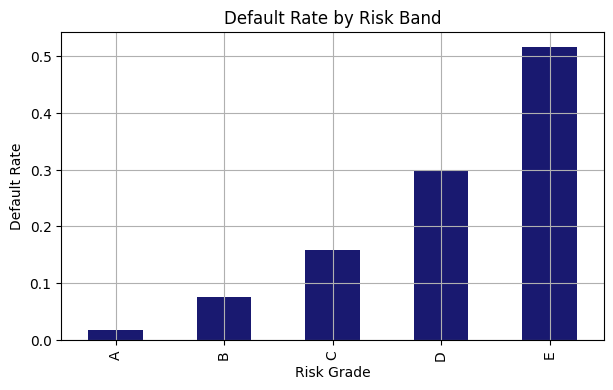

In [20]:
# Plot: Risk band vs. default rate
import matplotlib.pyplot as plt
default_rate.plot(kind='bar',color='midnightblue',figsize=(7,4))
plt.title("Default Rate by Risk Band")
plt.ylabel("Default Rate")
plt.xlabel("Risk Grade")
plt.grid(True)
plt.show()